In [1]:
!sudo add-apt-repository ppa:deadsnakes/ppa -y
!sudo apt-get update -y
!sudo apt-get install python3.12 python3.12-venv python3.12-dev -y
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.10 1
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.12 2
!sudo update-alternatives --set python3 /usr/bin/python3.12
!python3 -m ensurepip
!python3 -m pip install --upgrade pip
!python -V

Repository: 'deb https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu/ jammy main'
Description:
This PPA contains more recent Python versions packaged for Ubuntu.

Disclaimer: there's no guarantee of timely updates in case of security problems or other issues. If you want to use them in a security-or-otherwise-critical environment (say, on a production server), you do so at your own risk.

Update Note
Please use this repository instead of ppa:fkrull/deadsnakes.

Reporting Issues

Issues can be reported in the master issue tracker at:
https://github.com/deadsnakes/issues/issues

Supported Ubuntu and Python Versions

- Ubuntu 20.04 (focal) Python3.5 - Python3.7, Python3.9 - Python3.13
- Ubuntu 22.04 (jammy) Python3.7 - Python3.9, Python3.11 - Python3.13
- Ubuntu 24.04 (noble) Python3.7 - Python3.11, Python3.13
- Note: Python2.7 (focal, jammy), Python 3.8 (focal), Python 3.10 (jammy), Python3.12 (noble) are not provided by deadsnakes as upstream ubuntu provides those packages.

Why some

In [2]:
import math
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import yfinance as yf

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

from torch.autograd import Function
from torch import Tensor
import math
from typing import Tuple, Callable
from einops import rearrange

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
TICKER = 'ETH-USD'
PERIOD = '1y'
INTERVAL = '1h'
WINDOW_SIZE = 60
HORIZON = 12

df = yf.download(TICKER, period=PERIOD, interval=INTERVAL)[['Close']].dropna()

scaler = MinMaxScaler(feature_range=(0,1))
values = scaler.fit_transform(df.values)    # (N,1)

X, y = [], []
for i in range(len(values) - WINDOW_SIZE):
    X.append(values[i : i + WINDOW_SIZE])
    y.append(values[i + WINDOW_SIZE])

X = np.array(X)       # (samples, WINDOW_SIZE, 1)
y = np.array(y)       # (samples, 1)

split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

X_train_t = torch.from_numpy(X_train).float().to(device)
y_train_t = torch.from_numpy(y_train).float().to(device)
X_val_t   = torch.from_numpy(X_val).float().to(device)
y_val_t   = torch.from_numpy(y_val).float().to(device)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
class OneStepDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, i):
        return self.X[i], self.y[i]

batch_size = 64

train_ds = OneStepDataset(X_train_t, y_train_t)
val_ds   = OneStepDataset(X_val_t,   y_val_t)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

In [5]:
class PScan(Function):
    @staticmethod
    def forward(ctx, A_inp, X_inp):
        A, X = A_inp.clone(), X_inp.clone()
        A, X = rearrange(A, "l b d s -> b d l s"), rearrange(X, "l b d s -> b d l s")
        PScan._forward(A, X)
        ctx.save_for_backward(A.clone(), X)
        return rearrange(X, "b d l s -> b l d s")

    @staticmethod
    def backward(ctx, grad_inp: Tensor) -> Tuple[Tensor, Tensor]:
        A, X = ctx.saved_tensors
        A = torch.cat((A[:, :, :1], A[:, :, 1:].flip(2)), dim = 2)
        grad_out = rearrange(grad_inp, "b l d s -> b d l s").flip(2)
        PScan._forward(A, grad_out)
        Q = torch.zeros_like(X)
        Q[:, :, 1:].add_(X[:, :, :-1] * grad_out[:, :, 1:])
        return (rearrange(Q, "b d l s -> b l d s"),
                rearrange(grad_out, "b d l s -> b l d s"))

    @staticmethod
    def _forward(A: Tensor, X: Tensor) -> None:
        b, d, l, s = A.shape
        num_steps = int(math.log2(l))
        Av, Xv = A, X
        for _ in range(num_steps):
            T = Xv.size(2)
            Av, Xv = Av[:, :, :T].reshape(b, d, T//2, 2, -1), Xv[:, :, :T].reshape(b, d, T//2, 2, -1)
            Xv[:, :, :, 1].add_(Av[:, :, :, 1].mul(Xv[:, :, :, 0]))
            Av[:, :, :, 1].mul_(Av[:, :, :, 0])
            Av, Xv = Av[:, :, :, 1], Xv[:, :, :, 1]
        for k in range(num_steps-1, -1, -1):
            Av = A[:, :, 2**k - 1 : l : 2**k]
            Xv = X[:, :, 2**k - 1 : l : 2**k]
            T = 2*(Xv.size(2)//2)
            if T < Xv.size(2):
                Xv[:, :, -1].add_(Av[:, :, -1].mul(Xv[:, :, -2]))
                Av[:, :, -1].mul_(Av[:, :, -2])
            Av, Xv = Av[:, :, :T].reshape(b, d, T//2, 2, -1), Xv[:, :, :T].reshape(b, d, T//2, 2, -1)
            Xv[:, :, 1:, 0].add_(Av[:, :, 1:, 0].mul(Xv[:, :, :-1, 1]))
            Av[:, :, 1:, 0].mul_(Av[:, :, :-1, 1])

pscan: Callable[[Tensor, Tensor], Tensor] = PScan.apply

class RMSNorm(nn.Module):
    def __init__(self, d_model:int, eps:float=1e-8):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(d_model))
    def forward(self, x:Tensor)->Tensor:
        return x * torch.rsqrt(x.pow(2).mean(-1,keepdim=True)+self.eps) * self.weight

class MambaBlock(nn.Module):
    def __init__(self, d_input, d_model):
        super().__init__()
        self.in_proj   = nn.Linear(d_input,  d_model)
        self.s_B       = nn.Linear(d_model, d_model)
        self.s_C       = nn.Linear(d_model, d_model)
        self.out_proj  = nn.Linear(d_model, d_input)
    def forward(self, x):
        # x: (batch, seq_len, d_input)
        x = self.in_proj(x)
        B = self.s_B(x)
        C = self.s_C(x)
        return self.out_proj(x + B + C)

class Mamba(nn.Module):
    def __init__(self, num_layers, d_input, d_model):
        super().__init__()
        self.layers = nn.ModuleList([
            MambaBlock(d_input, d_model) for _ in range(num_layers)
        ])
    def forward(self, seq):
        # seq: (batch, seq_len, d_input)
        for m in self.layers:
            seq = m(seq)
        return seq

In [6]:
num_layers = 6
d_input = 1
d_model = 64

model = Mamba(num_layers, d_input, d_model).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [7]:
num_epochs = 20
train_losses, val_losses = [], []

for ep in range(1, num_epochs+1):
    model.train()
    total_tr, total_val = 0.0, 0.0

    for Xb, yb in train_loader:
        optimizer.zero_grad()
        out = model(Xb)               # (B, WINDOW_SIZE, 1)
        pred = out[:, -1, :]
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_tr += loss.item() * Xb.size(0)

    model.eval()
    with torch.no_grad():
        for Xb, yb in val_loader:
            out = model(Xb)
            pred = out[:, -1, :]
            total_val += criterion(pred, yb).item() * Xb.size(0)

    tr_loss = total_tr / len(train_loader.dataset)
    vl_loss = total_val / len(val_loader.dataset)
    train_losses.append(tr_loss)
    val_losses.append(vl_loss)

    print(f"Epoch {ep:02d} — Train MSE: {tr_loss:.6f} | Val MSE: {vl_loss:.6f}")

Epoch 01 — Train MSE: 0.017676 | Val MSE: 0.000050
Epoch 02 — Train MSE: 0.001133 | Val MSE: 0.000043
Epoch 03 — Train MSE: 0.000079 | Val MSE: 0.000045
Epoch 04 — Train MSE: 0.000079 | Val MSE: 0.000056
Epoch 05 — Train MSE: 0.000095 | Val MSE: 0.000044
Epoch 06 — Train MSE: 0.000091 | Val MSE: 0.000099
Epoch 07 — Train MSE: 0.000099 | Val MSE: 0.000074
Epoch 08 — Train MSE: 0.000098 | Val MSE: 0.000046
Epoch 09 — Train MSE: 0.000107 | Val MSE: 0.000045
Epoch 10 — Train MSE: 0.000143 | Val MSE: 0.000213
Epoch 11 — Train MSE: 0.000330 | Val MSE: 0.000276
Epoch 12 — Train MSE: 0.000918 | Val MSE: 0.008081
Epoch 13 — Train MSE: 0.003733 | Val MSE: 0.000048
Epoch 14 — Train MSE: 0.000085 | Val MSE: 0.000047
Epoch 15 — Train MSE: 0.000136 | Val MSE: 0.000523
Epoch 16 — Train MSE: 0.000147 | Val MSE: 0.000090
Epoch 17 — Train MSE: 0.000112 | Val MSE: 0.000173
Epoch 18 — Train MSE: 0.000100 | Val MSE: 0.000175
Epoch 19 — Train MSE: 0.000104 | Val MSE: 0.000046
Epoch 20 — Train MSE: 0.000127 

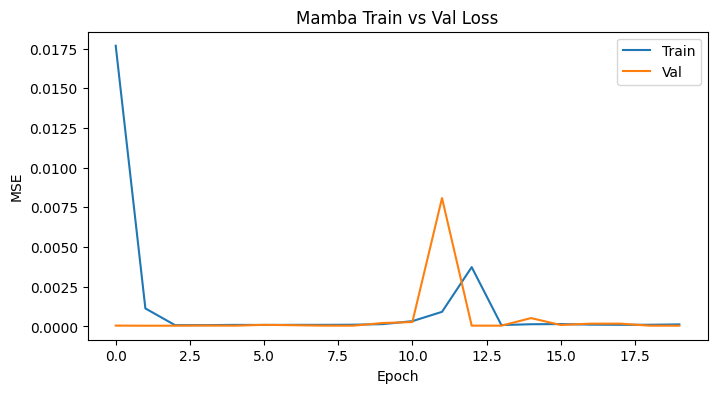

In [8]:
plt.figure(figsize=(8,4))
plt.plot(train_losses, label='Train')
plt.plot(val_losses,   label='Val')
plt.title('Mamba Train vs Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

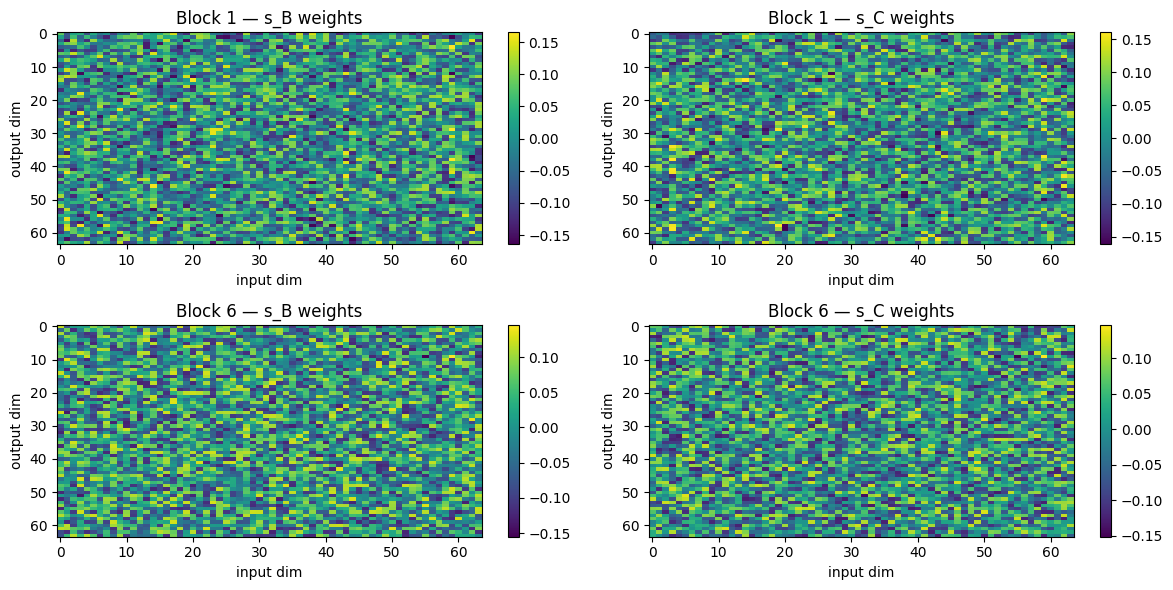

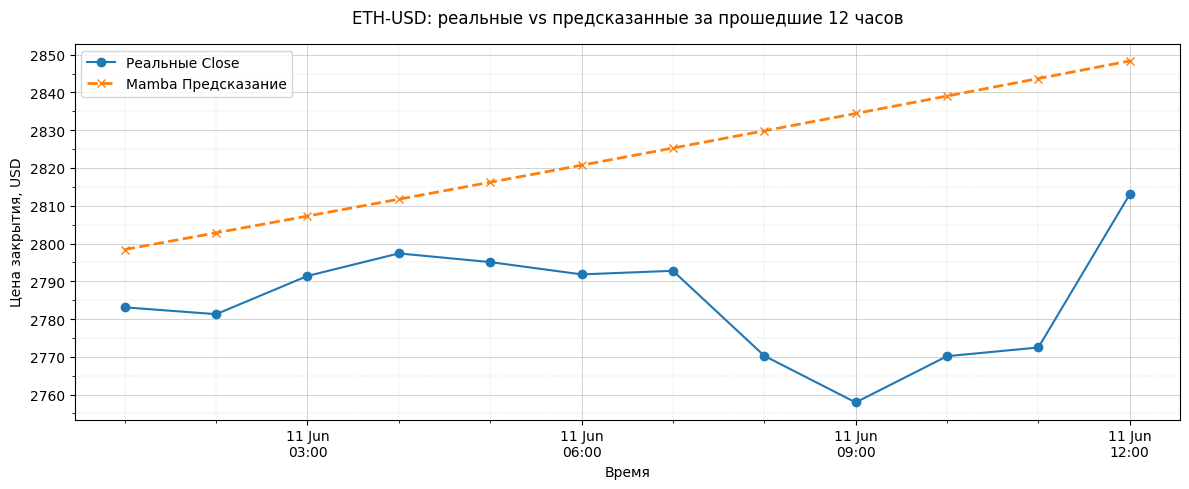

In [11]:
blocks = [0, num_layers-1]
fig, axes = plt.subplots(len(blocks), 2, figsize=(12, 6))

for i, idx in enumerate(blocks):
    Wb = model.layers[idx].s_B.weight.detach().cpu().numpy()  # (d_model, d_model)
    Wc = model.layers[idx].s_C.weight.detach().cpu().numpy()

    im0 = axes[i, 0].imshow(Wb, aspect='auto')
    axes[i, 0].set_title(f'Block {idx+1} — s_B weights')
    axes[i, 0].set_xlabel('input dim')
    axes[i, 0].set_ylabel('output dim')
    fig.colorbar(im0, ax=axes[i, 0])

    im1 = axes[i, 1].imshow(Wc, aspect='auto')
    axes[i, 1].set_title(f'Block {idx+1} — s_C weights')
    axes[i, 1].set_xlabel('input dim')
    axes[i, 1].set_ylabel('output dim')
    fig.colorbar(im1, ax=axes[i, 1])

plt.tight_layout()
plt.show()

hist_window = values[-WINDOW_SIZE-HORIZON : -HORIZON]
hist_dates  = df.index[-HORIZON:]

window = torch.from_numpy(hist_window).float().unsqueeze(0).to(device)
pred_past_scaled = []
model.eval()
with torch.no_grad():
    for _ in range(HORIZON):
        out = model(window)
        nxt = out[:, -1, :].cpu().numpy()
        pred_past_scaled.append(nxt[0, 0])
        nxt_t = torch.from_numpy(nxt).float().unsqueeze(1).to(device)
        window = torch.cat([window[:, 1:, :], nxt_t], dim=1)

pred_past_scaled = np.array(pred_past_scaled)
pred_past = scaler.inverse_transform(pred_past_scaled.reshape(-1,1)).flatten()
actual_past = scaler.inverse_transform(values[-HORIZON:].reshape(-1,1)).flatten()

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(hist_dates, actual_past, marker='o', label='Реальные Close', linewidth=1.5)
ax.plot(hist_dates, pred_past, marker='x', label='Mamba Предсказание', linewidth=2, linestyle='--')

ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0,24,3)))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b\n%H:%M'))
fig.autofmt_xdate(rotation=0, ha='center')

ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=10, prune='both'))
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(n=2))

ax.grid(which='major', linestyle='-', linewidth=0.5, alpha=0.8)
ax.grid(which='minor', linestyle='--', linewidth=0.3, alpha=0.5)

ax.set_title('ETH-USD: реальные vs предсказанные за прошедшие 12 часов', pad=15)
ax.set_xlabel('Время')
ax.set_ylabel('Цена закрытия, USD')
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

Выводы

1.	Динамика обучающей и валидационной потерь

  •	Потери на трейне за первую эпоху резко снижаются с ~0.018 до практически 0 уже к 2–3-й итерации, валидационная MSE тоже быстро падает.

  •	На 10–12-й эпохе видно небольшое «скачкообразное» увеличение валидационного лосса, что указывает на кратковременное переобучение. После этого обе кривые вновь сходятся к очень низкому уровню.

  •	В целом модель учится очень быстро, но её чувствительность к шуму валидации на средних эпохах говорит о необходимости тщательной ранней остановки или лёгкой регуляризации.
2.	Анализ весовых матриц s_B и s_C

  •	В первом блоке оба набора весов выглядят почти случайно, без выраженной диагональной структуры. Это ожидаемо: на входе модель ещё «не знает», какие комбинации фич важнее.

  •	В шестом, последнем блоке матрицы s_B и s_C более «однородны» по статистике, при этом по-прежнему не имеют ярко выраженной диагонали. Это говорит о том, что модель изучила некоторое «смешивание» признаков внутри каждого шага, но при этом не просто копирует вход (не жёсткая диагональ), а распределяет информацию между разными измерениями.

  •	Обе матрицы показывают, что Mamba реализует нетривиальное линейное преобразование в каждом шаге: веса становятся более «плотными» в глубине, что соответствует накоплению представлений.
3.	Реальные и предсказанные за прошедшие 12 часов

  •	Mamba продемонстрировала сильный трендовый прогноз: предсказанные значения монотонно растут (от ~2785 до ~2850), тогда как реальные данные колебались в диапазоне ~2780–2815.

  •	Явная систематическая переоценка и линейность предсказания объясняются кумулятивным эффектом итеративного одношагового forecast’а: малые ошибки напомаживаются при каждом следующем шаге.

  •	Модель плохо отреагировала на локальное падение в середине окна и не смогла воспроизвести «флет» в конце ряда.
4.	Сильные и слабые стороны

  •	Плюсы: сверхбыстрая сходимость, простая архитектура, лёгкость обучения без сложных механизмов attention.

  •	Минусы: кумулятивная ошибка в итеративном прогнозе, отсутствие механизма фокусировки на наиболее релевантных моментах (в отличие от self-attention), смещение прогноза при длительном форкасте.
5.	Идеи для улучшения

  •	Ввести мультишаговый loss (teacher forcing или прямой прогноз на 12 шагов), чтобы минимизировать нарастание погрешности.

  •	Добавить регуляризацию (weight decay, dropout внутри MambaBlock).

  •	Расширить входные признаки (например, объём торгов, скользящие средние), чтобы модель имела больше информации о структуре рынка.

  •	Попробовать гибридную схему: объединить Mamba-блоки с механикой attention для захвата глобальных зависимостей.